<br/>
<br/>

<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u>Modélisation Du Sinistre </u></h1>
<br/>
    

### Entrainement du modèle d'autoencodeur

In [1]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

base_Edu_cleaned est le dataFrame qui a été exporté dans le fichier préparation avant les réductions des dimensions

In [ ]:
base_assu= pd.read_parquet("C:/Users/damso/Documents/data/base_assu.parquet")

base_Edu=pd.read_csv("C:/Users/damso/Documents/data/base_Edu_cleaned.csv")

base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

In [10]:
base_Edu1 = pd.read_parquet("C:/Users/damso/Documents/data/base_Edu.parquet")

columns_delete= list(set(base_Edu1.columns) - set(base_Edu.columns))
len(columns_delete)

104

In [24]:
columns_delete

['delay_between_lesson_hours_std',
 'score_at_registration',
 'proportion_activities_last_7d_before_theory_exam',
 'time_q100_theme_score_pct_std_avg',
 'serie_q75_training_score_pct_avg_avg',
 'time_q100_theme_score_pct_avg_avg',
 'delay_between_first_and_last_booking_days',
 'delay_booking_lesson_days_std',
 'time_q100_training_count_avg',
 'serie_q25_training_score_pct_avg_avg',
 'nb_completed_exam_series',
 'proportion_activities_last_3d_before_theory_exam',
 'delay_between_lesson_hours_max',
 'serie_q50_exam_score_pct_std_avg',
 'score_before_exam',
 'time_q75_theme_score_pct_avg_avg',
 'serie_q50_training_score_pct_std_avg',
 'time_q75_theme_count_avg',
 'nb_distinct_meeting_point',
 'time_q50_exam_score_pct_std_avg',
 'delay_booking_lesson_days_min',
 'score_pct__fft_aggregated__aggtype_kurtosis',
 'time_q25_training_count_avg',
 'delay_annulation_lesson_days_avg',
 'time_q100_training_score_pct_std_avg',
 'time_q50_exam_score_pct_avg_avg',
 'serie_q100_theme_score_pct_avg_avg',

In [11]:


# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
oneencoder = OneHotEncoder(sparse_output=False)
encoded_cats = oneencoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = oneencoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

Epoch 1/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0447 - val_loss: 0.0306
Epoch 2/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0299 - val_loss: 0.0302
Epoch 3/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0295 - val_loss: 0.0298
Epoch 4/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0292 - val_loss: 0.0296
Epoch 5/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0289 - val_loss: 0.0293
Epoch 6/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0287 - val_loss: 0.0291
Epoch 7/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0284 - val_loss: 0.0289
Epoch 8/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0282 - val_loss: 0.0287
Epoch 9/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0281 - val_loss: 0.0286
Epoch 10/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0279 - val_loss: 0.0285
Epoch 11/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0278 - val_loss: 0.0284
Epoch 12/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/st

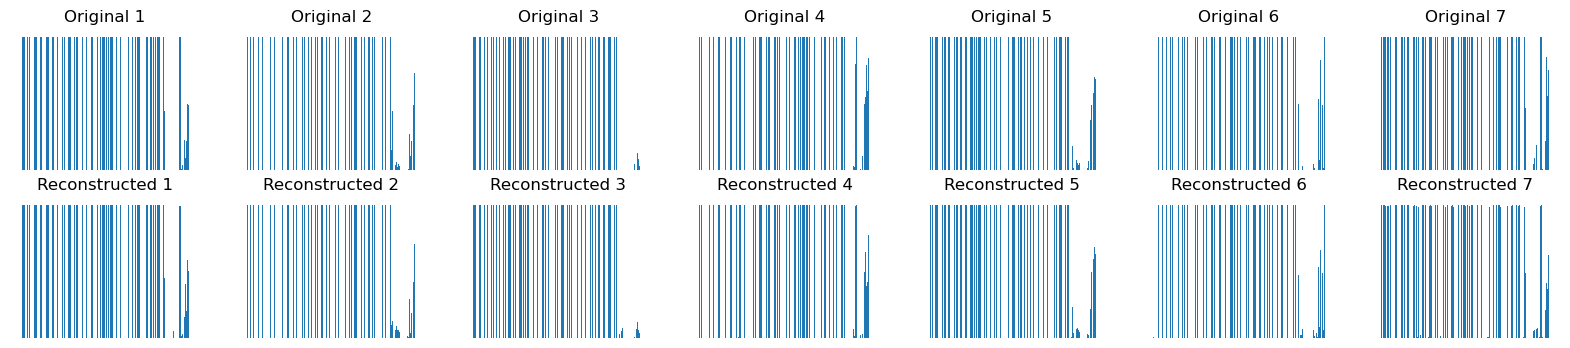

Erreur moyenne de reconstruction : 0.0280


In [33]:
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 3

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

input_img = Input(shape=(input_dim,))
# Encodeur
Hidden1 = Dense(358, activation='relu', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(358, activation='relu', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")

### importation de la base

In [37]:
#url = "C:/Users/damso/Documents/data/base_Edu.parquet"
df=base_assu
df.describe().T

,count,mean,min,25%,50%,75%,max,std
unique_learner_id,69398.0,3754957169445755.5,-9222849458566410240.0,-4598777253173660672.0,540777374478605.5,4626702790680507392.0,9223326892717478912.0,5329710092417094656.0
learner_id,69398.0,1583879.345644,364.0,728669.5,1497337.5,2308807.0,4457818.0,1001226.659264
days_between_signup_and_first_activity,69398.0,215.312142,0.0,0.0,27.0,269.0,3491.0,369.320062
days_between_order_and_first_activity,69398.0,141.204213,-2304.0,0.0,2.0,139.0,2912.0,338.464838
days_between_first_and_last_activities,69398.0,344.318583,0.0,85.0,241.0,489.0,2959.0,348.980921
...,...,...,...,...,...,...,...,...
var_Assurance11,69398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
var_Assurance12,69398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
var_Assurance13,69398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
var_Assurance14,69398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# restriction de la base Edu aux variables communes aux bases ASU et EDU
# pour voir les variables qui ne sont pas communes aux deux bases dans la base asu 
columns=[] # contient les colonnes communes aux deux bases 
for column in base_Edu1.columns:
    if column in df.columns:
        columns.append(column)
#base_AE=base_AE[columns]
df.drop(columns, axis=1)


,learner_id,job_number,unique_learner_id_1,days_between_signup_and_first_activity_1,days_between_order_and_first_activity_1,days_between_first_and_last_activities_1,chapter_before_success_count_1,serie_before_success_count_1,quiz_before_success_count_1,theory_activities_total_1,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,2032674,5952452787,-5911177134761577615,157,157,195,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
1,893514,6956583814,8022228279541171063,7,8,819,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
2,2858364,1547176297,4508976855497020988,0,-32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1362204,3464728867,2395000730355774468,0,0,376,0,0,0,288,...,0,1,3,0,0,0,0,0,0,0
4,1054230,1534163688,1056703805299986938,64,0,691,0,109,0,156,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,3793717,2234733812,-872146316430440559,0,0,372,0,57,18,193,...,0,0,0,0,0,0,0,0,0,0
69394,2775978,1784701608,-3415706474168471139,109,109,270,0,50,0,51,...,0,0,0,0,0,0,0,0,0,0
69395,2102507,7135995107,-1958338314080661076,672,665,613,0,93,321,603,...,0,0,0,0,0,0,0,0,0,0
69396,2862021,1866260241,-7394860117143701634,113,114,76,0,0,0,120,...,0,0,0,0,0,0,0,0,0,0


In [42]:
#suppression des colonnes doubles
columns_double=df.drop(columns, axis=1).drop(['learner_id',	'job_number','unique_learner_id_1','var_Assurance0', 'var_Assurance1', 'var_Assurance2', 'var_Assurance3',
       'var_Assurance4', 'var_Assurance5', 'var_Assurance6', 'var_Assurance7',
       'var_Assurance8', 'var_Assurance9', 'var_Assurance10',
       'var_Assurance11', 'var_Assurance12', 'var_Assurance13',
       'var_Assurance14', 'var_Assurance15'],axis=1).columns

df=df.drop(columns_double, axis=1)
df.head()

,unique_learner_id,learner_id,job_number,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,-5911177134761577615,2032674,5952452787,157,157,195,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
1,8022228279541171063,893514,6956583814,7,8,819,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
2,4508976855497020988,2858364,1547176297,0,-32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2395000730355774468,1362204,3464728867,0,0,376,0,0,0,288,...,0,1,3,0,0,0,0,0,0,0
4,1056703805299986938,1054230,1534163688,64,0,691,0,109,0,156,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# supression des lignes doubles
df = df.drop_duplicates()
df.shape

(66692, 489)

In [44]:
df.columns

Index(['unique_learner_id', 'learner_id', 'job_number',
       'days_between_signup_and_first_activity',
       'days_between_order_and_first_activity',
       'days_between_first_and_last_activities',
       'chapter_before_success_count', 'serie_before_success_count',
       'quiz_before_success_count', 'theory_activities_total',
       ...
       'var_Assurance6', 'var_Assurance7', 'var_Assurance8', 'var_Assurance9',
       'var_Assurance10', 'var_Assurance11', 'var_Assurance12',
       'var_Assurance13', 'var_Assurance14', 'var_Assurance15'],
      dtype='object', length=489)

In [45]:
# on supprime les variables qui ont été supprimer dans la base edu, ainsi que les variables inutiles
df_new=df.drop(columns_delete + ["unique_learner_id","learner_id","job_number","first_theory_activity_date",'unique_learner_id_1'], axis=1)


In [46]:
print(df_new.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(df_new.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(df_new.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(df_new.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

24  variables de type int ont des valeurs manquantes
24  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


In [47]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=df_new.select_dtypes("boolean").columns
for col in colboo:
    df_new[col] = encode_column_with_na(df_new[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories

In [48]:
miss_quant=df_new.select_dtypes(include=["int","float"]).isnull().sum()/len(df_new)
miss_quant[miss_quant>0.20].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [49]:
#imputation par la médiane
col=df_new.select_dtypes(exclude='category').columns
df_new[col] = df_new[col].fillna(df_new[col].median())

In [50]:
var_assurance=['var_Assurance0', 'var_Assurance1', 'var_Assurance2', 'var_Assurance3',
       'var_Assurance4', 'var_Assurance5', 'var_Assurance6', 'var_Assurance7',
       'var_Assurance8', 'var_Assurance9', 'var_Assurance10',
       'var_Assurance11', 'var_Assurance12', 'var_Assurance13',
       'var_Assurance14', 'var_Assurance15']

### Projection des variables dans l'espace latent

In [51]:
#on duplique l'observation pour qu'il n'y ait pas d'erreur lors de la division des données en données d'entrainement et données de test car la 
# stratification voudrait au moins deux observations par classe
df_duplicate = df_new[df_new["var_Assurance2"]==3]  # Sélection des lignes à dupliquer
df_new = pd.concat([df_new, df_duplicate], ignore_index=True)
df_new.shape

(66693, 380)

In [52]:
# traitement des données de la base ASU en entrée du modèle

X_to_predict= df_new.drop(var_assurance, axis=1)
# Récupérer les colonnes numériques et catégoriques
numerical_cols = X_to_predict.select_dtypes(include=['int', 'float']).columns
categorical_cols = X_to_predict.select_dtypes(include=['category', 'object','boolean']).columns

# Encodage des variables catégoriques avec OneHotEncoder
oneencoder = OneHotEncoder(sparse_output=False)
encoded_cats = oneencoder.fit_transform(X_to_predict[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = oneencoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(X_to_predict[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# construction du code latent pour la base ASU, projection dans l'espace latent de l'auto encodeur construit précédemment
encoded_imgs = encoder.predict(final_data)


2085/2085 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step


### **Prédiction du risque corporel**

In [57]:
#construction de la nouvelle base
nom_facteur=["facteur{}".format(i) for i in np.arange(1,4)]
col_to_delete = base_AE.columns.drop("first_theory_activity_date")
base = df_new.drop(col_to_delete, axis=1)
base[nom_facteur]=encoded_imgs
base.head()

,var_Assurance0,var_Assurance1,var_Assurance2,var_Assurance3,var_Assurance4,var_Assurance5,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15,facteur1,facteur2,facteur3
0,80,2.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.837339,2.159837,29.258821
1,3,1.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-8.336267,-0.476025,22.595692
2,78,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.800313,3.490731,29.080462
3,44,2.00,0,2,0,0,0,1,3,0,0,0,0,0,0,0,-8.192768,-1.574194,34.350758
4,91,1.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.790425,10.415071,17.511938


In [59]:
 # suppression des variables constantes
base=base.drop(["var_Assurance11","var_Assurance12","var_Assurance13","var_Assurance14"],axis=1)

Etant donnée que la variable cible est une variable de comptage, on fera l'hypothèse qu'elle suit une loi discrète classique. 

In [60]:
df_new["var_Assurance2"].mean()

0.006642376261376756

In [61]:
df_new["var_Assurance2"].var()

0.007348069143468633

# exportons à présent les données que nous utiliserons pour nos modélisation

In [62]:
base.to_csv("C:/Users/damso/Documents/data/base_model.csv", index=False,header=True,sep=";")

Etant donnée que la différence entre la moyenne et la variance de cette variable est négligeable (pas de surdispersion), nous allons considéré une distribution de poisson avec une fonction de lien logarithmique pour le modèle linéaire généralisé. 

### Implémentation d'un GLM poisson

<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation d'un GLM poisson(lisa)</u></h2>
<br/>
    

<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation d'un modèle XGBoost(briand)</u></h2>
<br/>
    

In [63]:
base = pd.read_csv("C:/Users/damso/Documents/data/base_model.csv")

In [71]:
base = pd.DataFrame(base)
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66693 entries, 0 to 66692
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                            Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                            --------------  ----- 
 0   var_Assurance0;var_Assurance1;var_Assurance2;var_Assurance3;var_Assurance4;var_Assurance5;var_Assurance6;var_Assurance7;var_Assurance8;var_Assurance9;var_Assurance10;var_Assurance15;facteur1;facteur2;facteur3  66693 non-null  object
dtypes: object(1)
memory usage: 521.2+ KB


In [72]:
# les variables var_assurance11 ... var_assurance14 sont constantes et ne contiennent que des 0
bodily=base["var_Assurance2"]
material=base["var_Assurance3"]
base=base.drop(["var_Assurance2","var_Assurance3"],axis=1)
base = base.astype(np.float64)
#base = np.asarray(base, dtype=np.float64)


KeyError: 'var_Assurance2'

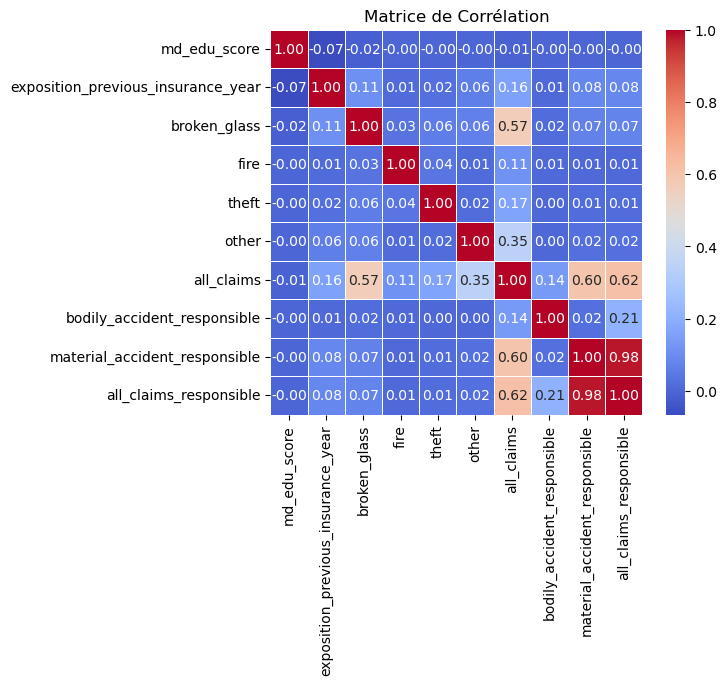

In [548]:
base_corr=base.drop(["facteur1","facteur2","facteur3"], axis=1)
base_corr.columns=["md_edu_score","exposition_previous_insurance_year","broken_glass","fire","theft","other","all_claims","bodily_accident_responsible","material_accident_responsible","all_claims_responsible"]
corr_matrix=base_corr.corr()
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

La variable var_Assurance15 (all_claims_responsible) est tres fortement correlée avec la variable var_Assurance10("material_accident_responsible") ce qui pourrait entrainer un problème de multicolinéarité dans le modèle. Aussi, la variable var_assurance8 est corréleé avec plusieurs variables. Analysons le VIF pour confirmer le fait que ces variables vont entrainer une forte colinéarité dans le modèle.

In [549]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calcul des VIF
print(compute_vif(base))

c:\Users\lisaw\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


           Variable       VIF
0    var_Assurance0  2.566259
1    var_Assurance1  3.312197
2    var_Assurance4  2.168289
3    var_Assurance5  1.033903
4    var_Assurance6  1.072066
5    var_Assurance7  1.416430
6    var_Assurance8  5.110304
7    var_Assurance9       inf
8   var_Assurance10       inf
9   var_Assurance15       inf
10         facteur1  1.234241
11         facteur2  2.166556
12         facteur3  3.448045


Un VIF= infini signifie que la variable est parfaitement corrélée avec une ou plusieurs autres variables. un VIF >5 suggère l'existence d'une forte multicolinéarité. On va donc supprimer les variables var_assurance15 et var_assurance8.

In [550]:
base=base.drop(["var_Assurance15","var_Assurance8"], axis=1)

In [551]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calcul des VIF
print(compute_vif(base))

           Variable       VIF
0    var_Assurance0  2.565425
1    var_Assurance1  3.286015
2    var_Assurance4  1.082060
3    var_Assurance5  1.004473
4    var_Assurance6  1.009719
5    var_Assurance7  1.032190
6    var_Assurance9  1.004634
7   var_Assurance10  1.092824
8          facteur1  1.234219
9          facteur2  2.165971
10         facteur3  3.446533


In [ ]:
Après suppression de ces variables, on a plus de problèmes de multicolinéarité forte.

In [589]:
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(base, bodily, test_size=0.3, stratify=bodily, random_state=40)
#x_train = scaler.fit_transform(x_train)
y_train.value_counts()

var_Assurance2
0    46391
1      279
2       13
3        2
Name: count, dtype: Int64

In [439]:
#from sklearn.model_selection import StratifiedShuffleSplit
# Création du split en respectant les proportions des classes
#sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#for train_index, test_index in sss.split(base, bodily):
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

 #Vérification de la distribution des classes
#print(y_train.value_counts(normalize=True))
#print(y_test.value_counts(normalize=True))

In [553]:
# suppression des variables une à une pour voir si l'on peut améliorer le modèle
import statsmodels.api as sm
deviance_glm_poisson=[]
for col in x_train.columns:
    glm_poisson = sm.GLM(np.asarray(y_train), np.asarray(sm.add_constant(x_train.drop(col,axis=1))), family=sm.families.Poisson()).fit()
    deviance_glm_poisson.append(round(glm_poisson.deviance,2))
deviance_glm_poisson

[1704.08,
 1722.75,
 1715.18,
 1705.31,
 1704.11,
 1707.76,
 3100.72,
 1714.9,
 1705.71,
 1708.06,
 1734.6]

On constate qu'en partant du modèle complet, aucune variable ne semble détériorer le modèle. On va donc retenir toutes ces variables pour la suite.

In [595]:
glm_poisson = sm.GLM(np.asarray(y_train), np.asarray(sm.add_constant(x_train)), family=sm.families.Poisson()).fit()
print(glm_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                46685
Model:                            GLM   Df Residuals:                    46673
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1151.0
Date:                Sat, 29 Mar 2025   Deviance:                       1704.1
Time:                        21:28:20   Pearson chi2:                 3.72e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.03084
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7829      0.212    -27.311      0.0

In [ ]:
# prédiction
#x_test = sm.add_constant(x_test)
pred_sinistres = glm_poisson.predict(sm.add_constant(x_test))

In [541]:
# calcul de la déviance sur les données de test
epsilon = 1e-10  # Pour éviter log(0)
deviance = 2 * np.sum(y_test * np.log((y_test + epsilon) / (pred_sinistres + epsilon)) - (y_test - pred_sinistres))
deviance

730.9509414861565

<Figure size 600x1000 with 0 Axes>

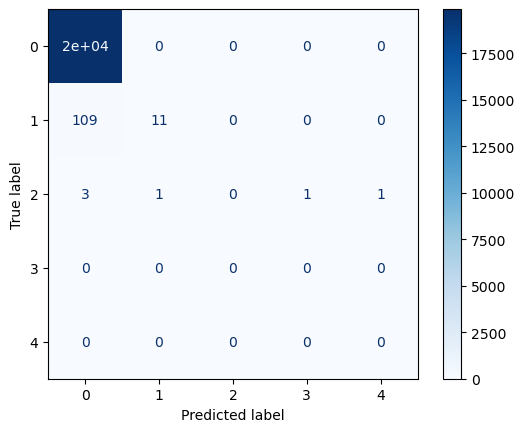

In [542]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(6,10))
cm = confusion_matrix(y_test, np.round(pred_sinistres))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

le modèle prédit des valeurs positives représentant des comptages attendus.
Le modèle prédit très mal les classes déséquilibrés.

### GLM avec XGBOOST

In [567]:
## ESSAI D'un GLM boosté
from xgboost import XGBRegressor
from sklearn.linear_model import PoissonRegressor

xgb = XGBRegressor(max_depth=1, objective='count:poisson')
xgb.fit(x_train, y_train)

y_pred_boosted = xgb.predict(x_test)
mse = mean_squared_error(y_test, y_pred_boosted)
print(f"Mean Squared Error (MSE) : {mse}")

Mean Squared Error (MSE) : 1.7623430512030957e-08


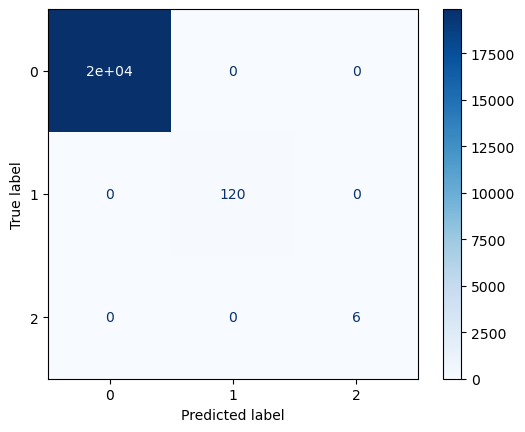

In [568]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.round(y_pred_boosted))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.frame import H2OFrame

# Initialisation de H2O
h2o.init()
x_train["nb_sinistres"]=y_train
x_test["nb_sinistres"]=y_test
# Conversion des données en format H2O
train_h2o = H2OFrame(x_train)
test_h2o = H2OFrame(x_test)

# Définition du modèle de Gradient Boosting avec une fonction de lien GLM (Poisson par ex.)
gbm_glm = H2OGradientBoostingEstimator(distribution="poisson",
                                       ntrees=200,
                                       learn_rate=0.1,
                                       max_depth=3)

# Entraînement du modèle
gbm_glm.train(x=list(x_train.columns), y="nb_sinistres", training_frame=train_h2o)

# Prédictions
predictions = gbm_glm.predict(test_h2o)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE) : {mse}")

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 day 23 hours 45 mins
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 27 days
H2O_cluster_name:,H2O_from_python_lisaw_3h5qh6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.390 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\lisaw\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


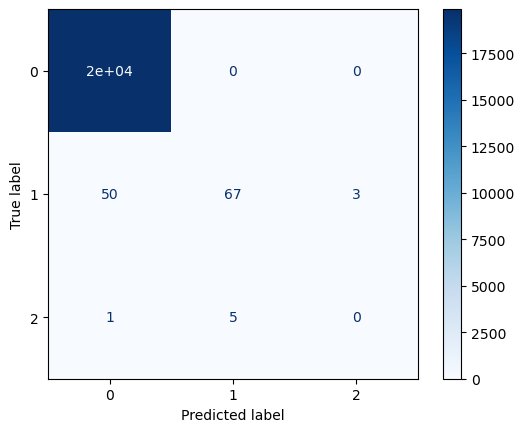

In [564]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.round(predictions.as_data_frame().values.flatten()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [581]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Définition du modèle de base : GLM Poisson
glm_base = PoissonRegressor()

# Application d'AdaBoost.R2 avec le GLM Poisson comme estimateur de base
adaboost_glm = AdaBoostRegressor(estimator=glm_base, n_estimators=10, learning_rate=0.2,random_state=42)
adaboost_glm.fit(pd.DataFrame(scaler.fit_transform(x_train),columns=x_train.columns), y_train)

# Prédictions
y_pred = adaboost_glm.predict(x_test)

# Évaluation des performances
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) : {mse}")

Mean Squared Error (MSE) : 0.007442439135873882


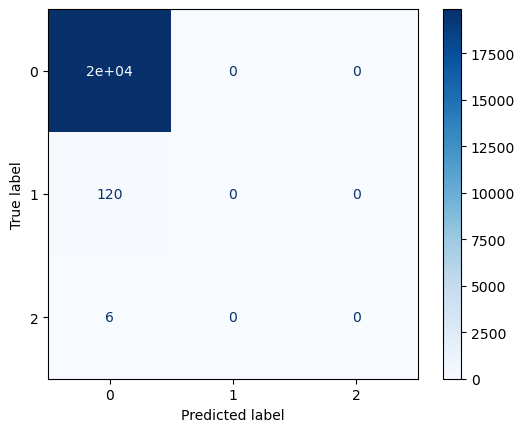

In [582]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.round(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### Utilisation des GLM avec le rééchantillonage SMOTE

In [584]:
from sklearn.model_selection import StratifiedShuffleSplit
#Création du split en respectant les proportions des classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(base, bodily):
    X_train, X_test = base.iloc[train_index], base.iloc[test_index]
    y_train, y_test = bodily.iloc[train_index], bodily.iloc[test_index]

#Vérification de la distribution des classes
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

var_Assurance2
0    0.993702
1    0.005979
2    0.000281
3    0.000037
Name: proportion, dtype: Float64
var_Assurance2
0    0.993703
1    0.005997
2      0.0003
Name: proportion, dtype: Float64


### **Prédiction du risque matériel** 

In [ ]:
## il semble mieux d'utiliser une loi binomiale négative pour cette variable

In [593]:
# Diviser les données en ensembles d'entraînement et de test
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(base, material, test_size=0.3, stratify=material, random_state=40)
#x_train = scaler.fit_transform(x_train)
y_train_m.value_counts()

var_Assurance3
0    40117
1     5326
2     1023
3      189
4       24
5        6
Name: count, dtype: Int64

In [597]:
# suppression des variables une à une pour voir si l'on peut améliorer le modèle
import statsmodels.api as sm
deviance_glm_poisson=[]
for col in x_train_m.columns:
    glm_poisson = sm.GLM(np.asarray(y_train_m), np.asarray(sm.add_constant(x_train_m.drop(col,axis=1))), family=sm.families.Poisson()).fit()
    deviance_glm_poisson.append(round(glm_poisson.deviance,2))
deviance_glm_poisson

[20600.48,
 20917.77,
 20697.53,
 20612.5,
 20599.47,
 20631.76,
 20603.75,
 31399.76,
 20607.79,
 20600.32,
 20605.04]

In [612]:
glm_poisson = sm.GLM(np.asarray(y_train_m), np.asarray(sm.add_constant(x_train_m)), family=sm.families.Poisson()).fit()
print(glm_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                46685
Model:                            GLM   Df Residuals:                    46673
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17294.
Date:                Sat, 29 Mar 2025   Deviance:                       20597.
Time:                        21:55:30   Pearson chi2:                 3.77e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2295
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7690      0.041    -67.071      0.0

In [613]:
pred_sinistres = glm_poisson.predict(sm.add_constant(x_test_m))

<Figure size 600x1000 with 0 Axes>

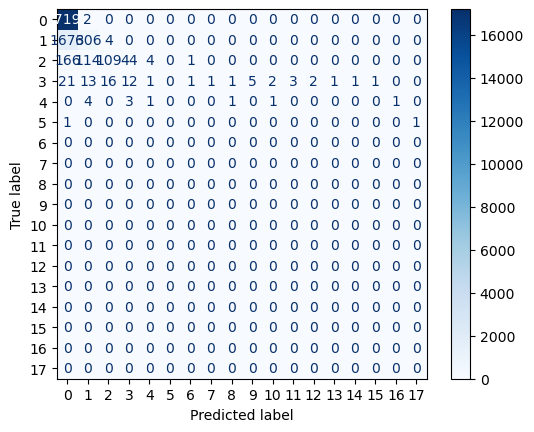

In [614]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(6,10))
cm = confusion_matrix(y_test_m, np.round(pred_sinistres))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [640]:
## ESSAI D'un GLM boosté
from xgboost import XGBRegressor
from sklearn.linear_model import PoissonRegressor

xgb = XGBRegressor(max_depth=5, objective='count:poisson')
xgb.fit(x_train_m, y_train_m)

y_pred_boosted = xgb.predict(x_test_m)
mse = mean_squared_error(y_test_m, y_pred_boosted)
print(f"Mean Squared Error (MSE) : {mse}")

Mean Squared Error (MSE) : 0.08971501776943283


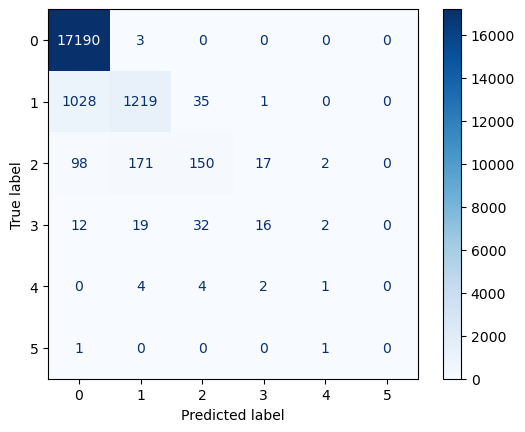

In [641]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_m, np.round(y_pred_boosted))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### GLM avec SMOTE

In [646]:
# Application de SMOTE sur les données d'entraînement
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={2: 5000, 3: 3000, 4:3000, 5:2000}, random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_m, y_train_m)

In [661]:
from xgboost import XGBRegressor
from sklearn.linear_model import PoissonRegressor

xgb = XGBRegressor(max_depth=5, objective='count:poisson')
xgb.fit(X_resampled, y_resampled)

y_pred_boosted = xgb.predict(x_test_m)
mse = mean_squared_error(y_test_m, y_pred_boosted)
print(f"Mean Squared Error (MSE) : {mse}")

Mean Squared Error (MSE) : 0.10297267678533864


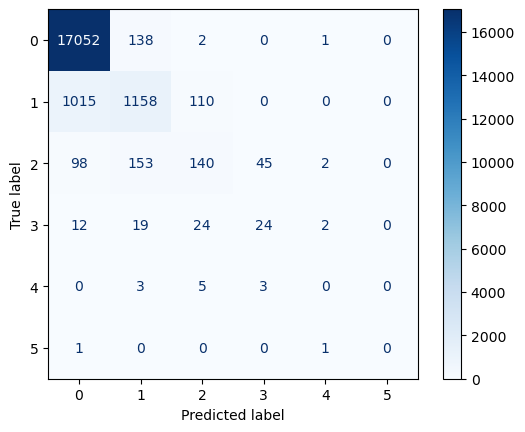

In [662]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_m, np.round(y_pred_boosted))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [651]:
y_train_m.value_counts()

var_Assurance3
0    40117
1     5326
2     1023
3      189
4       24
5        6
Name: count, dtype: Int64

In [660]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# SMOTE pour suréchantillonner les classes minoritaires
smote = SMOTE(sampling_strategy={1: 7000, 2: 4000,3:3000,4:2000,5:1000}, random_state=42)

# Downsampling de la classe majoritaire pour équilibrer le tout
undersample = RandomUnderSampler(sampling_strategy={0: 25000}, random_state=42)

# Pipeline combinant SMOTE + UnderSampling
pipeline = Pipeline([('smote', smote), ('undersample', undersample)])

# Application du pipeline
X_resampled, y_resampled = pipeline.fit_resample(x_train_m, y_train_m)

In [605]:
# modélisation avec une loi binomiale négative

model = sm.GLM(np.asarray(y_train_m), np.asarray(sm.add_constant(x_train_m)), family=sm.families.NegativeBinomial(alpha=1)).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                46685
Model:                            GLM   Df Residuals:                    46673
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17527.
Date:                Sat, 29 Mar 2025   Deviance:                       15378.
Time:                        21:48:31   Pearson chi2:                 4.09e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.2051
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0333      0.050    -60.612      0.0

In [606]:
pred_sinistres = model.predict(sm.add_constant(x_test_m))

<Figure size 3000x1600 with 0 Axes>

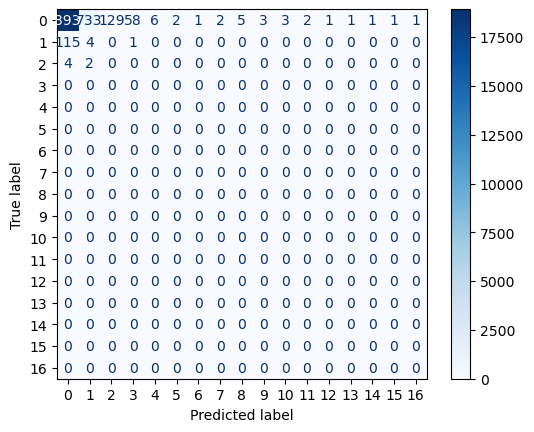

In [664]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(30,16))
cm = confusion_matrix(y_test, np.round(pred_sinistres))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation d'une regression logistique (deeson)</u></h2>
<br/>
    